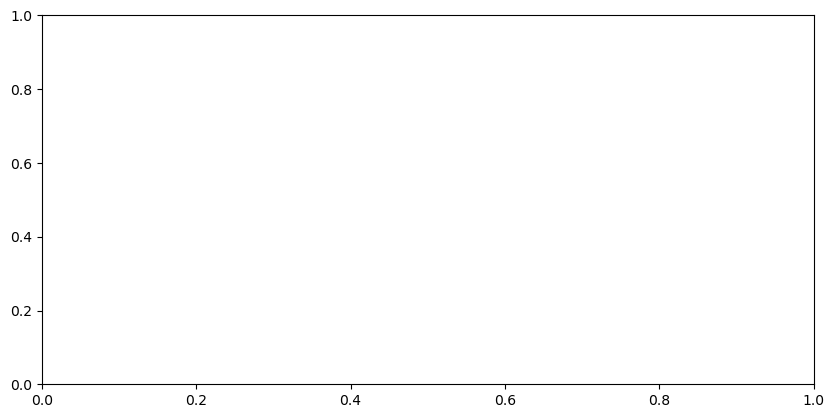

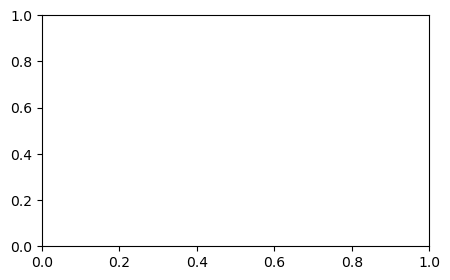

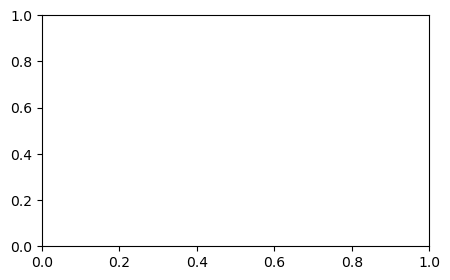

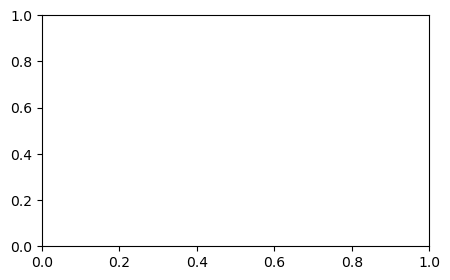

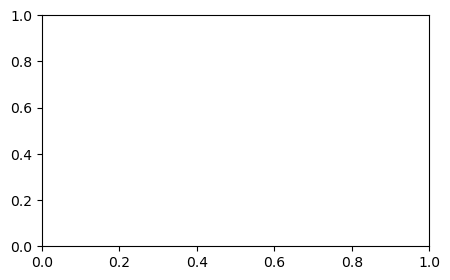

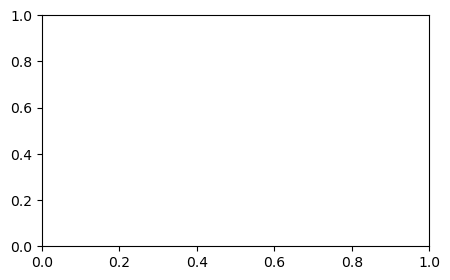

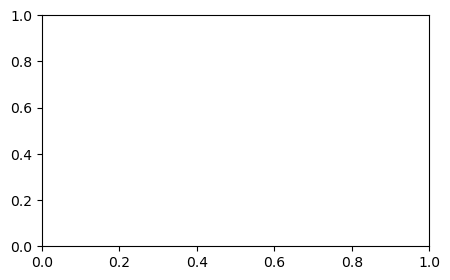

In [3]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

# Girdi değişkenleri
kiralanma_suresi = ctrl.Antecedent(np.arange(1, 31, 1), 'kiralanma_suresi')
araba_tipi = ctrl.Antecedent(np.arange(1, 4, 1), 'araba_tipi')
sezon = ctrl.Antecedent(np.arange(1, 4, 1), 'sezon')
musteri_sadakati = ctrl.Antecedent(np.arange(0, 11, 1), 'musteri_sadakati')
ek_hizmetler = ctrl.Antecedent(np.arange(0, 6, 1), 'ek_hizmetler')

# Çıktı değişkenleri
fiyat = ctrl.Consequent(np.arange(0, 101, 1), 'fiyat')
indirim = ctrl.Consequent(np.arange(0, 51, 1), 'indirim')

# Üyelik fonksiyonları
kiralanma_suresi['kisa'] = fuzz.trimf(kiralanma_suresi.universe, [1, 1, 10])
kiralanma_suresi['orta'] = fuzz.trimf(kiralanma_suresi.universe, [5, 15, 25])
kiralanma_suresi['uzun'] = fuzz.trimf(kiralanma_suresi.universe, [20, 30, 30])

araba_tipi['kucuk'] = fuzz.trimf(araba_tipi.universe, [1, 1, 1.5])
araba_tipi['orta'] = fuzz.trimf(araba_tipi.universe, [1.5, 2, 2.5])
araba_tipi['buyuk'] = fuzz.trimf(araba_tipi.universe, [2.5, 3, 3])

sezon['dusuk'] = fuzz.trimf(sezon.universe, [1, 1, 1.5])
sezon['orta'] = fuzz.trimf(sezon.universe, [1.5, 2, 2.5])
sezon['yuksek'] = fuzz.trimf(sezon.universe, [2.5, 3, 3])

musteri_sadakati['dusuk'] = fuzz.trimf(musteri_sadakati.universe, [0, 0, 4])
musteri_sadakati['orta'] = fuzz.trimf(musteri_sadakati.universe, [3, 5, 7])
musteri_sadakati['yuksek'] = fuzz.trimf(musteri_sadakati.universe, [6, 10, 10])

ek_hizmetler['yok'] = fuzz.trimf(ek_hizmetler.universe, [0, 0, 1])
ek_hizmetler['az'] = fuzz.trimf(ek_hizmetler.universe, [0, 2, 4])
ek_hizmetler['cok'] = fuzz.trimf(ek_hizmetler.universe, [3, 5, 5])

fiyat['dusuk'] = fuzz.trimf(fiyat.universe, [0, 0, 40])
fiyat['orta'] = fuzz.trimf(fiyat.universe, [30, 50, 70])
fiyat['yuksek'] = fuzz.trimf(fiyat.universe, [60, 100, 100])

indirim['yok'] = fuzz.trimf(indirim.universe, [0, 0, 10])
indirim['az'] = fuzz.trimf(indirim.universe, [5, 15, 30])
indirim['fazla'] = fuzz.trimf(indirim.universe, [25, 50, 50])

# Kurallar
rules = [
    ctrl.Rule(kiralanma_suresi['kisa'] & araba_tipi['kucuk'] & sezon['dusuk'], (fiyat['dusuk'], indirim['fazla'])),
    ctrl.Rule(kiralanma_suresi['uzun'] | musteri_sadakati['yuksek'], indirim['fazla']),
    ctrl.Rule(sezon['yuksek'] & araba_tipi['buyuk'], fiyat['yuksek']),
    ctrl.Rule(ek_hizmetler['cok'], fiyat['yuksek']),
    ctrl.Rule(musteri_sadakati['dusuk'] & kiralanma_suresi['kisa'], indirim['yok']),
    ctrl.Rule(sezon['orta'] & araba_tipi['orta'], fiyat['orta']),
    ctrl.Rule(ek_hizmetler['az'] & kiralanma_suresi['orta'], fiyat['orta']),
    ctrl.Rule(musteri_sadakati['orta'] & kiralanma_suresi['orta'], indirim['az']),
]

fiyat_ctrl = ctrl.ControlSystem(rules)
fiyat_sim = ctrl.ControlSystemSimulation(fiyat_ctrl)

# GUI Başlat
root = tk.Tk()
root.title("Araba Kiralama Tahmin Sistemi")
root.geometry("1000x700")

notebook = ttk.Notebook(root)
notebook.pack(expand=True, fill="both")

frames = []
figures = []
canvases = []
axes_list = []

labels = [
    "Kiralanma Süresi", "Araba Tipi", "Sezon",
    "Müşteri Sadakati", "Ek Hizmetler", "Fiyat", "İndirim"
]

for i in range(7):
    frame = ttk.Frame(notebook)
    notebook.add(frame, text=labels[i])
    fig, ax = plt.subplots(figsize=(5, 3))
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.get_tk_widget().pack(fill='both', expand=True)

    frames.append(frame)
    figures.append(fig)
    canvases.append(canvas)
    axes_list.append(ax)

# Giriş Paneli
frame_input = ttk.Frame(root, padding=10)
frame_input.pack(side='top', fill='x')

def kategori_fiyat(deger):
    if deger < 35:
        return "Düşük"
    elif deger < 65:
        return "Orta"
    else:
        return "Yüksek"

def kategori_indirim(deger):
    if deger < 10:
        return "Yok"
    elif deger < 30:
        return "Az"
    else:
        return "Fazla"

def hesapla():
    try:
        ks = float(entry_ks.get())
        at = float(entry_at.get())
        sz = float(entry_sz.get())
        ms = float(entry_ms.get())
        eh = float(entry_eh.get())

        fiyat_sim.input['kiralanma_suresi'] = ks
        fiyat_sim.input['araba_tipi'] = at
        fiyat_sim.input['sezon'] = sz
        fiyat_sim.input['musteri_sadakati'] = ms
        fiyat_sim.input['ek_hizmetler'] = eh

        fiyat_sim.compute()
        fiyat_sonuc = fiyat_sim.output['fiyat']
        indirim_sonuc = fiyat_sim.output['indirim']

        label_sonuc.config(text=f"Fiyat: {fiyat_sonuc:.2f} TL ({kategori_fiyat(fiyat_sonuc)})\n"
                                f"İndirim: {indirim_sonuc:.2f}% ({kategori_indirim(indirim_sonuc)})")

        plot_grafikler(ks, at, sz, ms, eh, fiyat_sonuc, indirim_sonuc)

    except Exception as e:
        messagebox.showerror("Hata", f"Hesaplama yapılamadı.\n{str(e)}")

def plot_grafikler(ks, at, sz, ms, eh, fiyat_sonuc, indirim_sonuc):
    girdiler = [kiralanma_suresi, araba_tipi, sezon, musteri_sadakati, ek_hizmetler]
    degerler = [ks, at, sz, ms, eh]
    for i, (var, val) in enumerate(zip(girdiler, degerler)):
        ax = axes_list[i]
        ax.clear()
        for label in var.terms:
            mf = var.terms[label].mf
            ax.plot(var.universe, mf, label=label)
        ax.axvline(val, color='r', linestyle='--')
        ax.set_title(labels[i])
        ax.legend()
        canvases[i].draw()

    # Fiyat grafiği
    ax = axes_list[5]
    ax.clear()
    for label in fiyat.terms:
        mf = fiyat.terms[label].mf
        ax.plot(fiyat.universe, mf, label=label)
    ax.axvline(fiyat_sonuc, color='r', linestyle='--', label='Tahmini')
    ax.set_title("Fiyat")
    ax.legend()
    canvases[5].draw()

    # İndirim grafiği
    ax = axes_list[6]
    ax.clear()
    for label in indirim.terms:
        mf = indirim.terms[label].mf
        ax.plot(indirim.universe, mf, label=label)
    ax.axvline(indirim_sonuc, color='r', linestyle='--', label='Tahmini')
    ax.set_title("İndirim")
    ax.legend()
    canvases[6].draw()

# Giriş Alanları
ttk.Label(frame_input, text="Kiralanma Süresi (1-30):").grid(row=0, column=0)
entry_ks = ttk.Entry(frame_input, width=5)
entry_ks.grid(row=0, column=1)

ttk.Label(frame_input, text="Araba Tipi (1=Küçük, 2=Orta, 3=Büyük):").grid(row=1, column=0)
entry_at = ttk.Entry(frame_input, width=5)
entry_at.grid(row=1, column=1)

ttk.Label(frame_input, text="Sezon (1=Yaz, 2=Kış, 3=sonbahar):").grid(row=2, column=0)
entry_sz = ttk.Entry(frame_input, width=5)
entry_sz.grid(row=2, column=1)

ttk.Label(frame_input, text="Müşteri Sadakati (0-10):").grid(row=3, column=0)
entry_ms = ttk.Entry(frame_input, width=5)
entry_ms.grid(row=3, column=1)

ttk.Label(frame_input, text="Ek Hizmetler (0-5):").grid(row=4, column=0)
entry_eh = ttk.Entry(frame_input, width=5)
entry_eh.grid(row=4, column=1)

ttk.Button(frame_input, text="Hesapla", command=hesapla).grid(row=5, column=0, columnspan=2, pady=10)

label_sonuc = ttk.Label(frame_input, text="Sonuç burada gösterilecek", font=("Segoe UI", 12))
label_sonuc.grid(row=6, column=0, columnspan=2)

root.mainloop()
